In [6]:
# Initial imports
import time
start = time.time()

import os
import sys
import IPython
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import wavfile
from scipy.fft import fft, fftfreq
from scipy.signal import spectrogram, find_peaks

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import pickle


end = time.time()
print(f'Imports took {end-start} seconds')


Imports took 0.0 seconds


In [7]:
major_files_path = 'Audio_Files/Major/'
minor_files_path = 'Audio_files/Minor/'
major_sample_1 = 'Major_0.wav'

IPython.display.Audio(f'{major_files_path}{major_sample_1}', rate=44100)

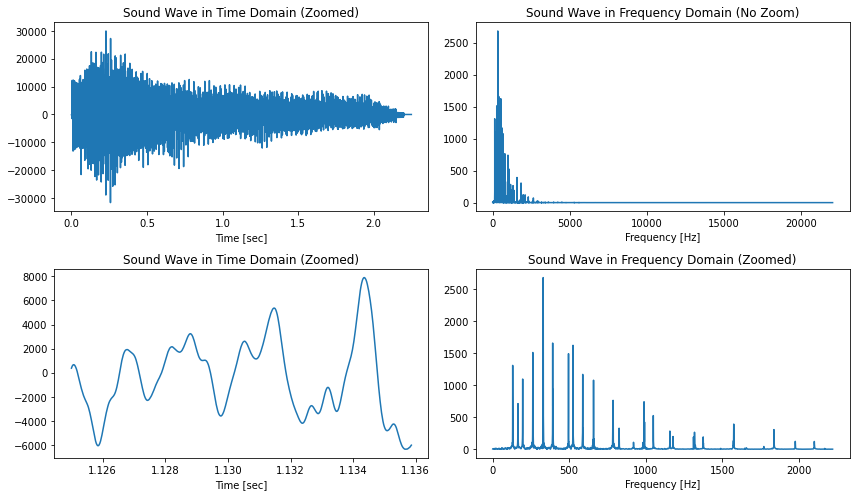

In [8]:
# Code referenced from another notebook by Ahmet Celik
fs, signal = wavfile.read(f'{major_files_path}{major_sample_1}') # get a frequency sample and signal from a wavfile
N = len(signal)
time = np.linspace(0., N/fs, N)

# Fourier Transform
y_freq = fftfreq(N, 1/fs)[:N//2] # array for frequency stamps
signal_f = fft(signal) # Signal in frequency domain
signal_f_onesided = 2.0/N * np.abs(signal_f[0:N//2]) # postive terms

# Plotting signal in time and frequency domains
fig, axes = plt.subplots(2, 2, figsize=(12, 7))
axes[0,0].plot(time, signal)
axes[0,0].set_title("Sound Wave in Time Domain (Zoomed)")
axes[0,0].set(xlabel="Time [sec]")
axes[0,1].plot(y_freq, signal_f_onesided)
axes[0,1].set_title("Sound Wave in Frequency Domain (No Zoom)")
axes[0,1].set(xlabel="Frequency [Hz]")

axes[1,0].plot(time[(N//2):(N//2+480)], signal[(N//2):(N//2+480)])
axes[1,0].set_title("Sound Wave in Time Domain (Zoomed)")
axes[1,0].set(xlabel="Time [sec]")
axes[1,1].plot(y_freq[:5000], signal_f_onesided[:5000])
axes[1,1].set_title("Sound Wave in Frequency Domain (Zoomed)")
axes[1,1].set(xlabel="Frequency [Hz]")
fig.tight_layout()
plt.show()

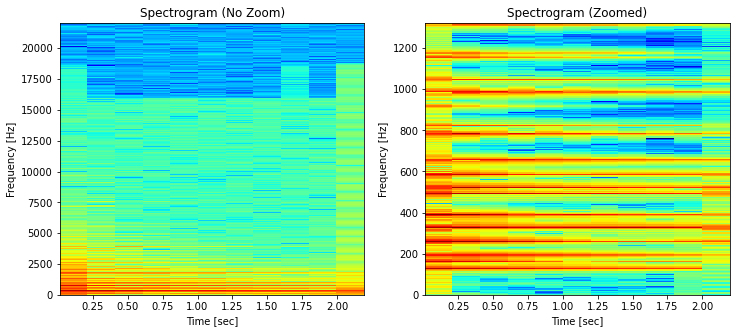

In [9]:
# applying spectrogram
f, t, Sxx = spectrogram(signal, fs, nperseg=10000, nfft=50000)

# Plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].pcolormesh(t, f, np.log(Sxx), cmap='jet', shading='auto')
axes[0].set_title('Spectrogram (No Zoom)')
axes[0].set(xlabel='Time [sec]', ylabel='Frequency [Hz]')
axes[1].pcolormesh(t, f[:1500], np.log(Sxx)[:1500,:], cmap='jet', shading='auto')
axes[1].set_title('Spectrogram (Zoomed)')
axes[1].set(xlabel='Time [sec]', ylabel='Frequency [Hz]')
plt.show()

Harmonics: [ 131.  165.  196.  262.  330.  392.  496.  525.  588.  659.  787.  826.
  989. 1050. 1158. 1179. 1312. 1319. 1376. 1576. 1838.]


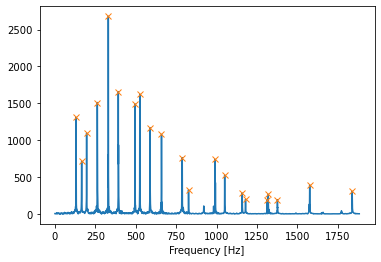

In [10]:
# h: height treshold. Defined as 5% of the max value
h = signal_f_onesided.max()*.05
peaks, _ = find_peaks(signal_f_onesided, distance=10, height=h)

freq_50_index = np.abs(y_freq - 50).argmin() # finding index for 50 Hz
peaks = peaks[peaks > freq_50_index] # filtering peaks less than 50 Hz
harmonics = y_freq[peaks]
print(f'Harmonics: {np.round(harmonics)}')

# Plot
i = peaks.max() + 100
plt.plot(y_freq[:i], signal_f_onesided[:i])
plt.plot(y_freq[peaks], signal_f_onesided[peaks], 'x')
plt.xlabel('Frequency [Hz]')
plt.show()

In [11]:
# Method to read sound file, apply Fourier Transformation, find and return peak frequencies
# Input: 
# --- path = path of sound file
# --- print_peaks = true to plot peaks
# Output: Frequency peaks

def find_harmonics(path, print_peaks=False):
    fs, X = wavfile.read(path)
    N = len(X)
    X_F = fft(X)
    X_F_onesided = 2.0/N * np.abs(X_F[0:N//2])
    freqs = fftfreq(N, 1/fs)[:N//2]
    freqs_50_index = np.abs(freqs - 50).argmin()
    
    h = X_F_onesided.max()*.05
    peaks, _ = find_peaks(X_F_onesided, distance=10, height=h)
    peaks = peaks[peaks > freq_50_index]
    harmonics = np.round(freqs[peaks], 2)
    if print_peaks:
        i = peaks.max() + 100
        plt.plot(freqs[:i], X_F_onesided[:i])
        plt.plot(freqs[peaks], X_F_onesided[peaks], 'x')
        plt.xlabel('Frequency [Hz]')
        plt.show()
    return harmonics

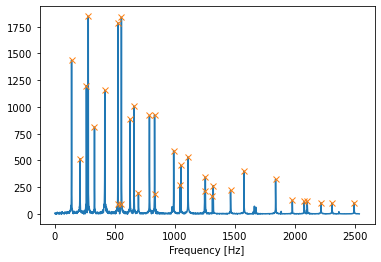

Harmonics: [ 139.  209.  262.  278.  330.  415.  525.  530.  550.  554.  626.  659.
  696.  787.  830.  834.  989. 1043. 1050. 1109. 1247. 1253. 1313. 1319.
 1463. 1575. 1838. 1978. 2077. 2102. 2217. 2309. 2493.]


In [12]:
# Another example to check if method is working correctly
minor_sample_1 = 'Minor_10.wav'
harmonics_2 = find_harmonics(f'{minor_files_path}{minor_sample_1}', print_peaks=True)
print(f'Harmonics: {np.round(harmonics_2)}')

***Importing Dataset***

In [23]:
path = 'Audio_Files'
data = []
max_harm_length = 0 # i will keep track of max harmonic length for naming columns
# Stopping here 4/19

# Begin from 4/20
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        foldername = os.path.basename(dirname)
        full_path = os.path.join(dirname, filename)
        freq_peaks = find_harmonics(full_path)
        
        max_harm_length = max(max_harm_length, len(freq_peaks))
        
        ind_data = [foldername, filename]
        ind_data.extend([freq_peaks.min(), freq_peaks.max(), len(freq_peaks)])
        ind_data.extend(freq_peaks)
        
        data.append(ind_data)
        
print(data)

[['Major', 'Major_0.wav', 130.67, 1838.22, 21, 130.67, 165.33, 196.0, 262.22, 330.22, 392.0, 495.56, 524.89, 588.44, 659.11, 787.11, 826.22, 989.33, 1049.78, 1158.22, 1178.67, 1312.44, 1319.11, 1376.0, 1575.56, 1838.22], ['Major', 'Major_1.wav', 131.11, 993.33, 16, 131.11, 165.33, 174.67, 196.44, 261.78, 266.67, 331.11, 340.0, 392.44, 496.0, 524.0, 589.78, 655.56, 661.33, 919.11, 993.33], ['Major', 'Major_10.wav', 130.91, 1408.64, 20, 130.91, 185.0, 234.09, 262.27, 329.55, 370.45, 393.18, 468.18, 555.45, 659.09, 702.73, 741.36, 788.18, 927.27, 937.73, 989.55, 1113.18, 1172.73, 1319.09, 1408.64], ['Major', 'Major_100.wav', 155.45, 2449.09, 27, 155.45, 195.91, 278.18, 311.36, 349.55, 392.27, 466.82, 556.36, 588.18, 622.73, 699.09, 778.64, 784.55, 835.0, 935.0, 1050.0, 1091.36, 1112.73, 1178.64, 1248.18, 1375.91, 1391.82, 1399.09, 1573.64, 1670.45, 1949.09, 2449.09], ['Major', 'Major_101.wav', 155.91, 1093.64, 20, 155.91, 175.45, 196.82, 273.18, 278.18, 283.18, 311.36, 316.36, 341.82, 350

In [24]:
# Column Names for DataFrame:
cols = ["Chord Type", "File Name", "Min Harmonic", "Max Harmonic", "# of Harmonics"]
for i in range(max_harm_length):
    cols.append("Harmonic {}".format(i+1))

# Creating DataFrame
df = pd.DataFrame(data, columns=cols)
df.head()

,Chord Type,File Name,Min Harmonic,Max Harmonic,# of Harmonics,Harmonic 1,Harmonic 2,Harmonic 3,Harmonic 4,Harmonic 5,...,Harmonic 29,Harmonic 30,Harmonic 31,Harmonic 32,Harmonic 33,Harmonic 34,Harmonic 35,Harmonic 36,Harmonic 37,Harmonic 38
0,Major,Major_0.wav,130.67,1838.22,21,130.67,165.33,196.00,262.22,330.22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Major,Major_1.wav,131.11,993.33,16,131.11,165.33,174.67,196.44,261.78,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Major,Major_10.wav,130.91,1408.64,20,130.91,185.00,234.09,262.27,329.55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Major,Major_100.wav,155.45,2449.09,27,155.45,195.91,278.18,311.36,349.55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Major,Major_101.wav,155.91,1093.64,20,155.91,175.45,196.82,273.18,278.18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


***Data Exploration***

In [25]:
# The target we are going to evaluate
df["Chord Type"].value_counts()

Major    502
Minor    357
Name: Chord Type, dtype: int64

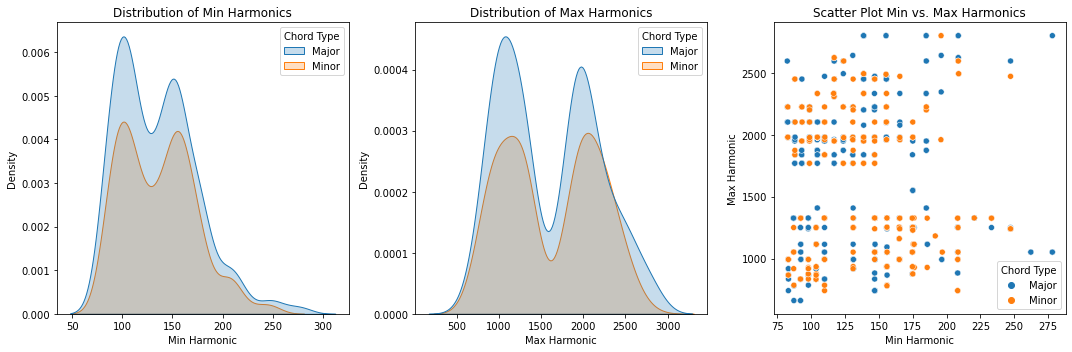

In [26]:
# Min and Max Harmonics
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.kdeplot(ax=axes[0], data=df, x="Min Harmonic", hue="Chord Type", shade=True)
sns.kdeplot(ax=axes[1], data=df, x="Max Harmonic", hue="Chord Type", shade=True)
sns.scatterplot(ax=axes[2], data=df, x="Min Harmonic", y="Max Harmonic",hue="Chord Type")
axes[0].set_title("Distribution of Min Harmonics")
axes[1].set_title("Distribution of Max Harmonics")
axes[2].set_title("Scatter Plot Min vs. Max Harmonics")
fig.tight_layout()
plt.show()

In [27]:
# Number of Harmonics
df["# of Harmonics"].describe()

count    859.000000
mean      20.389988
std        6.656608
min        8.000000
25%       15.000000
50%       20.000000
75%       25.000000
max       38.000000
Name: # of Harmonics, dtype: float64

In [28]:
print("Number of Missing values:")
miss_values = df.isnull().sum().sort_values(ascending=False)
miss_values[miss_values>0]

Number of Missing values:


Harmonic 38    858
Harmonic 37    857
Harmonic 36    855
Harmonic 35    847
Harmonic 34    839
Harmonic 33    829
Harmonic 32    813
Harmonic 31    793
Harmonic 30    773
Harmonic 29    754
Harmonic 28    720
Harmonic 27    682
Harmonic 26    656
Harmonic 25    611
Harmonic 24    551
Harmonic 23    501
Harmonic 22    471
Harmonic 21    438
Harmonic 20    406
Harmonic 19    382
Harmonic 18    345
Harmonic 17    306
Harmonic 16    241
Harmonic 15    191
Harmonic 14    150
Harmonic 13    108
Harmonic 12     74
Harmonic 11     46
Harmonic 10     20
Harmonic 9      10
dtype: int64

In [29]:
# Feature Engineering on Harmonics
df_original = df.copy() # Keeping original of df, I may need later

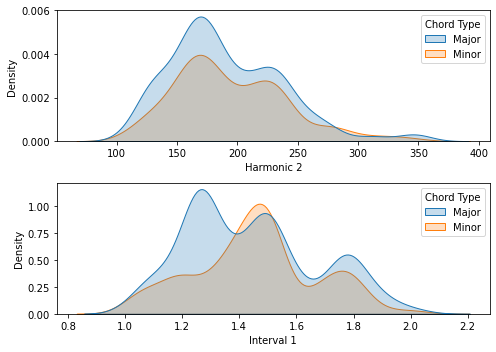

In [30]:
df["Interval 1"] = df["Harmonic 2"].div(df["Harmonic 1"], axis=0)

fig, axes = plt.subplots(2, 1, figsize=(7, 5))
sns.kdeplot(ax=axes[0], data=df, x="Harmonic 2", hue="Chord Type", shade=True)
sns.kdeplot(ax=axes[1], data=df, x="Interval 1", hue="Chord Type", shade=True)
fig.tight_layout()
plt.show()

In [31]:
df = df_original.copy() # refreshing df

for i in range(1,21):
    curr_interval = "Interval {}".format(i)
    curr_harm = "Harmonic {}".format(i+1)
    prev_harm = "Harmonic {}".format(i)
    df[curr_interval] = df[curr_harm].div(df[prev_harm], axis=0)
    
df.head()

,Chord Type,File Name,Min Harmonic,Max Harmonic,# of Harmonics,Harmonic 1,Harmonic 2,Harmonic 3,Harmonic 4,Harmonic 5,...,Interval 11,Interval 12,Interval 13,Interval 14,Interval 15,Interval 16,Interval 17,Interval 18,Interval 19,Interval 20
0,Major,Major_0.wav,130.67,1838.22,21,130.67,165.33,196.00,262.22,330.22,...,1.049688,1.197417,1.061102,1.103298,1.017656,1.113492,1.005082,1.043128,1.145029,1.166709
1,Major,Major_1.wav,131.11,993.33,16,131.11,165.33,174.67,196.44,261.78,...,1.125534,1.111533,1.008802,1.389790,1.080752,NaN,NaN,NaN,NaN,NaN
2,Major,Major_10.wav,130.91,1408.64,20,130.91,185.00,234.09,262.27,329.55,...,1.054971,1.063154,1.176470,1.011280,1.055261,1.124936,1.053495,1.124803,1.067888,NaN
3,Major,Major_100.wav,155.45,2449.09,27,155.45,195.91,278.18,311.36,349.55,...,1.113791,1.007590,1.064304,1.119760,1.122995,1.039390,1.019581,1.059233,1.059000,1.102333
4,Major,Major_101.wav,155.91,1093.64,20,155.91,175.45,196.82,273.18,278.18,...,1.188654,1.191808,1.060464,1.057780,1.251999,1.069225,1.120785,1.124279,1.038861,NaN


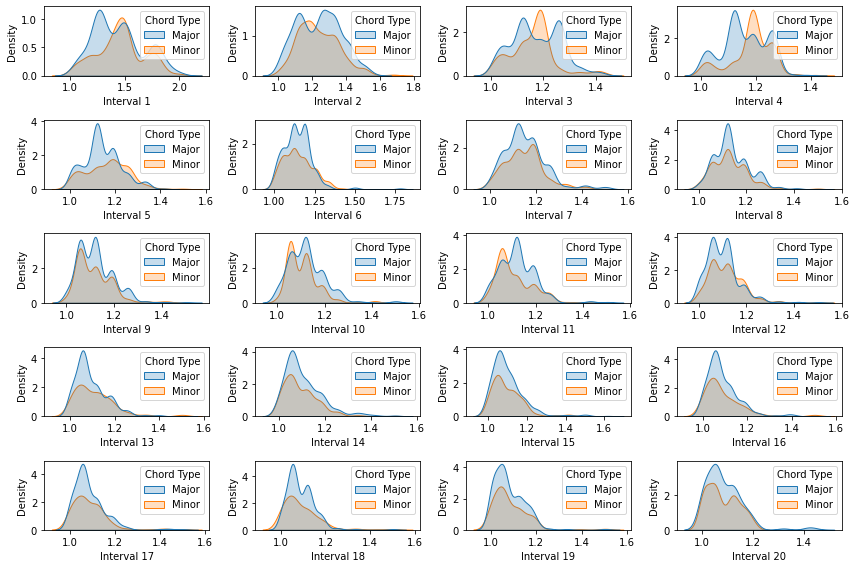

In [32]:
# Lets plot them
fig, axes = plt.subplots(5, 4, figsize=(12, 8))
for i in range(1,21):
    plt.subplot(5, 4, i)
    sns.kdeplot(data=df, x="Interval {}".format(i), hue="Chord Type", shade=True)
fig.tight_layout()
plt.show()

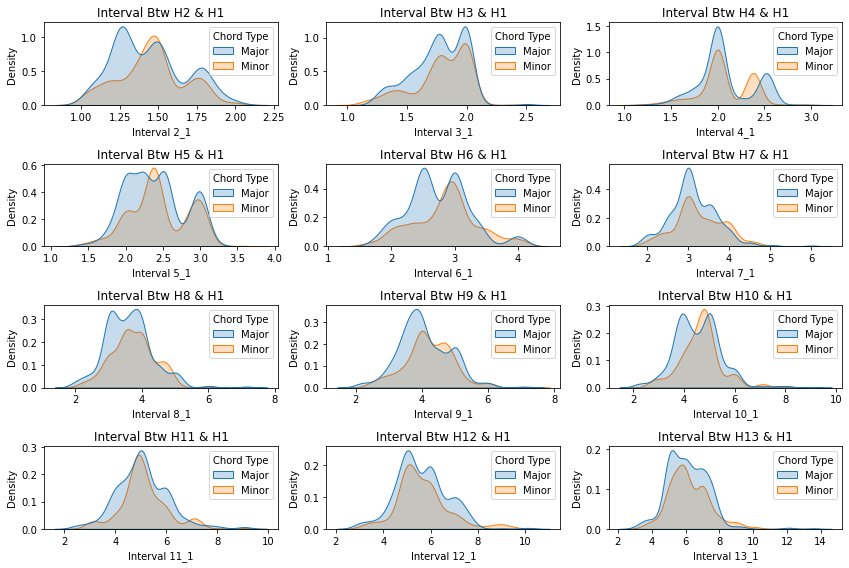

In [33]:
fig, axes = plt.subplots(4, 3, figsize=(12, 8))
for i in range(2,14):
    curr_interval = "Interval {}_1".format(i)
    curr_harm = "Harmonic {}".format(i)
    df[curr_interval] = df[curr_harm].div(df["Harmonic 1"], axis=0)
    
    plt.subplot(4, 3, i-1)
    plt.gca().set_title("Interval Btw H{} & H1".format(i))
    sns.kdeplot(data=df, x=curr_interval, hue="Chord Type", shade=True)
fig.tight_layout()
plt.show()